In [1]:
#Importiamo le librerie necessarie
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, probplot
from random import choice, seed
from tqdm import tqdm
import seaborn as sns
from itertools import combinations
from sklearn.linear_model import LinearRegression #ci serve per poter utilizzare la regressione lineare
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

Importiamo il file "Measurement_summary.csv" su python utilizzando pandas e rendiamolo Dataframe "df". Per evitare di modificare il dataframe originale andiamo a creare una copia e chiamiamola "Measurement_summary". Il parametro "deep=True" serve per evitare che le modifiche effettuare al dataset Measurement_summary vadano a modificare il dataframe originale. Facciamo lo stesso anche per il file "Measurement_item_info.csv".

In [2]:
df = pd.read_csv("archive/AirPollutionSeoul/Measurement_summary.csv")
Measurement_summary = df.copy(deep=True)

df1 = pd.read_csv("archive/AirPollutionSeoul/Original Data/Measurement_item_info.csv")
Measurement_item_info = df1.copy(deep=True)

Notiamo che la colonna "Measurement date" contiene dati di tipo "oggetto". Convertiamo questi ultimi in dati di tipo "data"

In [3]:
# Convertiamo la colonna 'Measurement date' in un oggetto datetime (integrazione)
Measurement_summary['Measurement date'] = pd.to_datetime(Measurement_summary['Measurement date'], format='%Y-%m-%d %H:%M')

# Verifichiamo il risultato
print("\n*** Informazioni sul dataset con modifica della colonna Measurement date ***\n")
print(Measurement_summary.info())


*** Informazioni sul dataset con modifica della colonna Measurement date ***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647511 entries, 0 to 647510
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Measurement date  647511 non-null  datetime64[ns]
 1   Station code      647511 non-null  int64         
 2   Address           647511 non-null  object        
 3   Latitude          647511 non-null  float64       
 4   Longitude         647511 non-null  float64       
 5   SO2               647511 non-null  float64       
 6   NO2               647511 non-null  float64       
 7   O3                647511 non-null  float64       
 8   CO                647511 non-null  float64       
 9   PM10              647511 non-null  float64       
 10  PM2.5             647511 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 54.3+ MB
None


Creiamo ora degli array:
1. distretti: array che contiene tutti gli station code contenuti in "Measurement_summary.csv"
2. anni: array che contiene tutti gli anni in cui sono state effettuate le misurazioni contenuti in "Measurement_summary.csv"
3. inquinanti: array che contiene tutti gli inquinanti che sono contenuti in "Measurement_item_info.csv"

In [4]:
#Creo array che contiene tutte le stazioni di misurazione (tutti i distretti)
distretti = Measurement_summary["Station code"].unique()
print('\n*** I distretti presi in esame sono: ***\n', distretti)

#Creo array che contiene tutti gli anni di rilevazione
anni = Measurement_summary["Measurement date"].dt.year.unique()  

#Creo array che contiene tutti gli inquinanti
inquinanti = Measurement_item_info["Item name"].unique()
print('\n*** Gli inquinanti presi in esame sono: ***\n',inquinanti)


*** I distretti presi in esame sono: ***
 [101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125]

*** Gli inquinanti presi in esame sono: ***
 ['SO2' 'NO2' 'CO' 'O3' 'PM10' 'PM2.5']


Andiamo a sostituire i valori negativi con NaN (Not a Number). 

In [5]:
# Individuo solo le colonne numeriche
numeric_cols = Measurement_summary.select_dtypes(include=[np.number]).columns
# Sostituisco i valori negativi con NaN solo nelle colonne numeriche
Measurement_summary[numeric_cols] = Measurement_summary[numeric_cols].mask(Measurement_summary[numeric_cols] < 0, np.nan)
#print(Measurement_summary)

Ora andiamo ad eliminare gli outlier (valori fuori scala rispetto a tutti gli altri)

In [6]:
tutti_gli_indici_fuori_scala = 0

for inquinante in inquinanti:
    # Calcolo la media e la deviazione standard della colonna dell'inquinante
    media = Measurement_summary[inquinante].mean()
    deviazione_std = Measurement_summary[inquinante].std()

    # Imposto un fattore (es. 3 per considerare valori oltre 3 deviazioni standard come outlier)
    fattore = 3
    soglia_superiore = media + fattore * deviazione_std

    # Trovo gli indici delle righe che contengono valori considerati outlier
    indici_fuori_scala = Measurement_summary[Measurement_summary[inquinante] > soglia_superiore].index
    tutti_gli_indici_fuori_scala += len(indici_fuori_scala)
    
    # Sostituisco i valori outlier con NaN
    Measurement_summary.loc[indici_fuori_scala, inquinante] = np.nan

    # Stampo per monitorare i cambiamenti
    print(f"Outlier per {inquinante}: {len(indici_fuori_scala)} sostituiti con NaN")

# Stampo il totale degli indici fuori scala trovati
print(f"Totale valori outlier sostituiti con NaN: {tutti_gli_indici_fuori_scala}")

Outlier per SO2: 485 sostituiti con NaN
Outlier per NO2: 6 sostituiti con NaN
Outlier per CO: 1867 sostituiti con NaN
Outlier per O3: 74 sostituiti con NaN
Outlier per PM10: 1786 sostituiti con NaN
Outlier per PM2.5: 1491 sostituiti con NaN
Totale valori outlier sostituiti con NaN: 5709


Ora normalizziamo tutti i dati in modo tale da rendere più chiara la visualizzazione

In [7]:
# Creazione dello scaler
scaler = MinMaxScaler()
df_norm = Measurement_summary.copy(deep=True)
df_norm[inquinanti] = scaler.fit_transform(Measurement_summary[inquinanti])
#print(df_norm)

Passiamo ora ai modelli di machine learning. Iniziamo con la regressione lineare

Regressione lineare con colonne "Anno", "Mese", "Giorno dell'anno" e categorizzando "Station code", "Anno", "Mese", "Giorno dell'anno". Inoltre per la previsione usiamo anche le concentrazioni degli altri inquinanti

In [8]:
df_norm_originale = df_norm.copy(deep=True)
print(df_norm_originale)

          Measurement date  Station code  \
0      2017-01-01 00:00:00           101   
1      2017-01-01 01:00:00           101   
2      2017-01-01 02:00:00           101   
3      2017-01-01 03:00:00           101   
4      2017-01-01 04:00:00           101   
...                    ...           ...   
647506 2019-12-31 19:00:00           125   
647507 2019-12-31 20:00:00           125   
647508 2019-12-31 21:00:00           125   
647509 2019-12-31 22:00:00           125   
647510 2019-12-31 23:00:00           125   

                                                  Address   Latitude  \
0       19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016   
1       19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016   
2       19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016   
3       19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016   
4       19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016   
...                                    


Lavorando su: SO2
                            OLS Regression Results                            
Dep. Variable:                    SO2   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                 1.711e+04
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:57:54   Log-Likelihood:             7.3477e+05
No. Observations:              510137   AIC:                        -1.470e+06
Df Residuals:                  510127   BIC:                        -1.469e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0975      

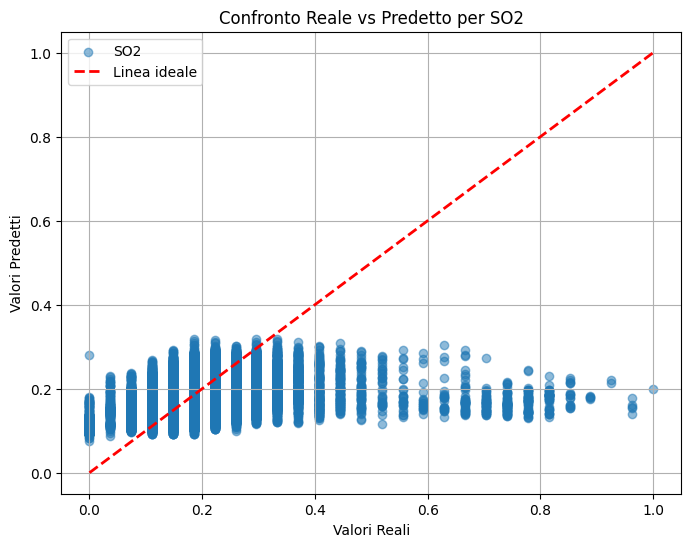


Lavorando su: NO2
                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                 7.521e+04
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:57:55   Log-Likelihood:             8.9312e+05
No. Observations:              510137   AIC:                        -1.786e+06
Df Residuals:                  510127   BIC:                        -1.786e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0522      

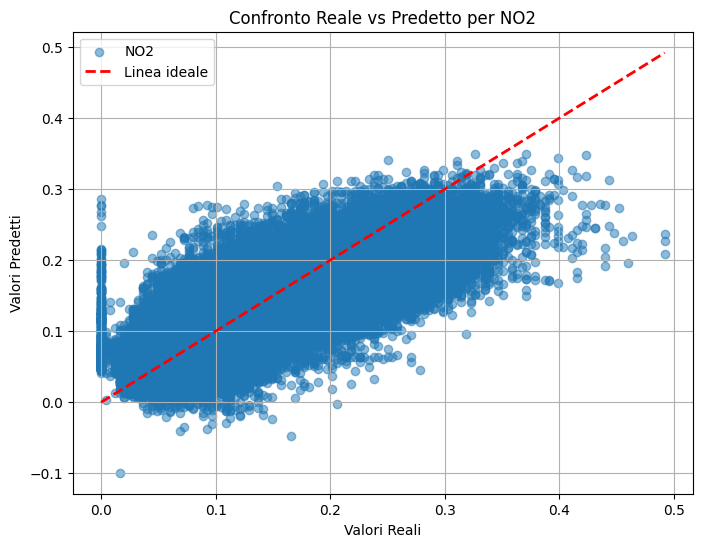


Lavorando su: CO
                            OLS Regression Results                            
Dep. Variable:                     CO   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                 7.237e+04
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:57:56   Log-Likelihood:             4.5511e+05
No. Observations:              510137   AIC:                        -9.102e+05
Df Residuals:                  510127   BIC:                        -9.101e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1311      0

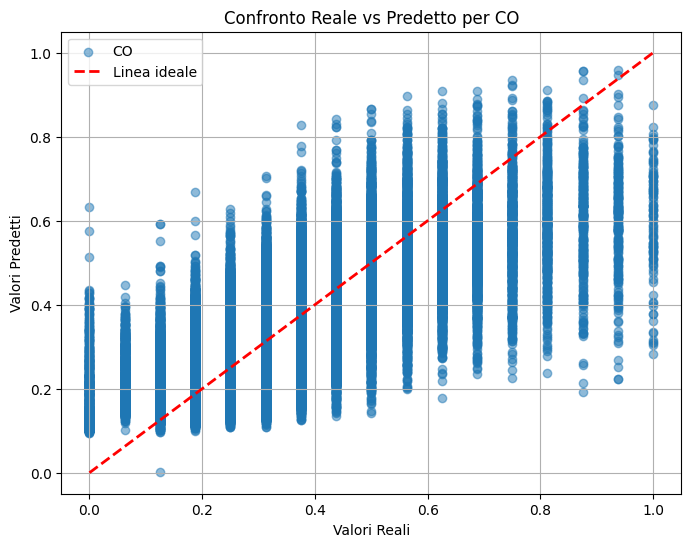


Lavorando su: O3
                            OLS Regression Results                            
Dep. Variable:                     O3   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                 2.664e+04
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:57:58   Log-Likelihood:             5.5137e+05
No. Observations:              510137   AIC:                        -1.103e+06
Df Residuals:                  510127   BIC:                        -1.103e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2083      0

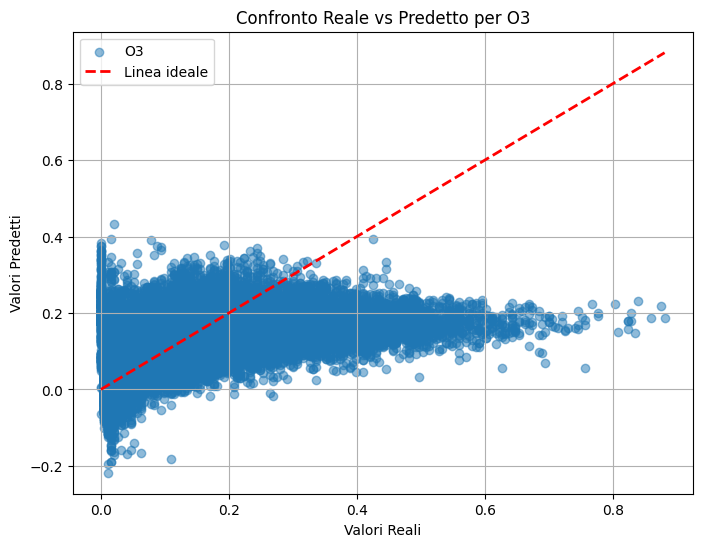


Lavorando su: PM10
                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                 1.370e+05
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:57:59   Log-Likelihood:             7.1642e+05
No. Observations:              510137   AIC:                        -1.433e+06
Df Residuals:                  510127   BIC:                        -1.433e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0105     

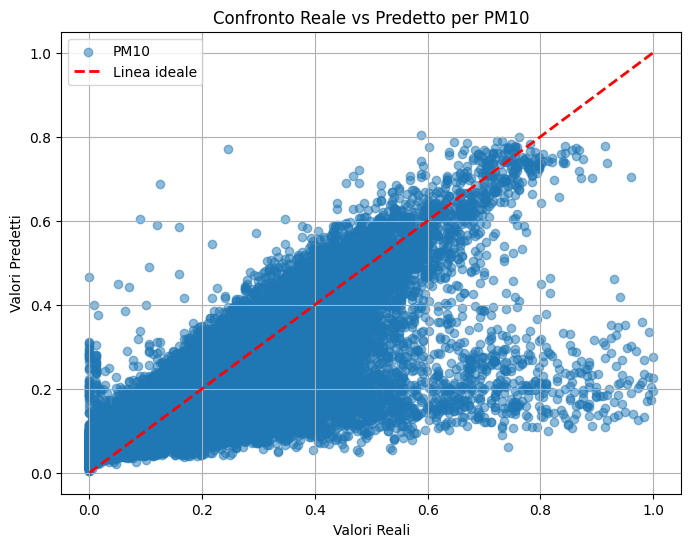


Lavorando su: PM2.5
                            OLS Regression Results                            
Dep. Variable:                  PM2.5   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                 1.557e+05
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:58:01   Log-Likelihood:             7.0400e+05
No. Observations:              510137   AIC:                        -1.408e+06
Df Residuals:                  510127   BIC:                        -1.408e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0371    

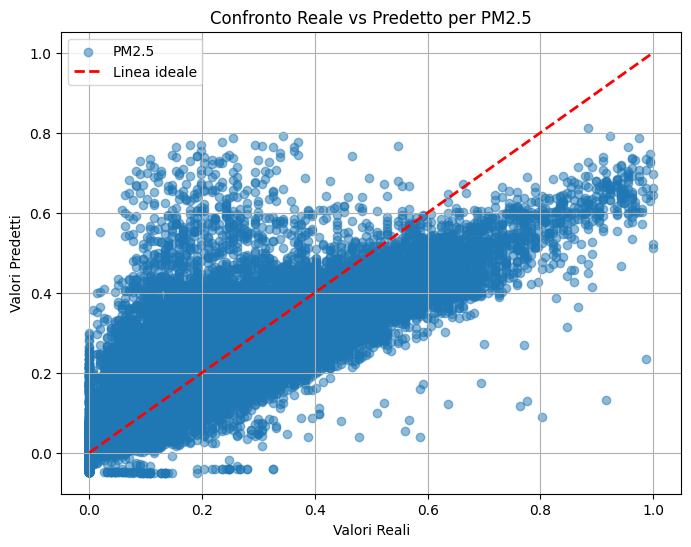



Risultati complessivi:
SO2: MSE=0.0034, R^2=0.1771
NO2: MSE=0.0018, R^2=0.5881
CO: MSE=0.0083, R^2=0.5764
O3: MSE=0.0063, R^2=0.3459
PM10: MSE=0.0042, R^2=0.6830
PM2.5: MSE=0.0042, R^2=0.7194


In [9]:
#print(df_norm_originale)
df_norm = df_norm_originale.copy(deep=True)
# Codifico la data come caratteristiche numeriche (esempio: giorno dell'anno, anno, mese)
df_norm['Day_of_year'] = df_norm['Measurement date'].dt.dayofyear
df_norm['Year'] = df_norm['Measurement date'].dt.year
df_norm['Month'] = df_norm['Measurement date'].dt.month

# Converto Station code, Day_of_year, Year, Month in categorie
df_norm['Station code'] = df_norm['Station code'].astype('category').cat.codes
df_norm['Day_of_year'] = df_norm['Day_of_year'].astype('category').cat.codes
df_norm['Year'] = df_norm['Year'].astype('category').cat.codes
df_norm['Month'] = df_norm['Month'].astype('category').cat.codes

# Dizionario per salvare i risultati
result_dict = {}

for inquinante in inquinanti:
    print(f"\nLavorando su: {inquinante}")
    
    # Creo una lista di altri inquinanti, escludendo quello corrente
    altri_inquinanti = [altro for altro in inquinanti if altro != inquinante]
    
    # Preparo i dati
    columns = ['Day_of_year', 'Year', 'Month', 'Station code'] + altri_inquinanti + [inquinante]
    data = df_norm[columns].dropna()  # Rimuovo righe con valori mancanti
    X = data[['Day_of_year', 'Year', 'Month', 'Station code'] + altri_inquinanti]
    y = data[inquinante]
    
    # Aggiungo un termine di bias (intercept) a X
    X = sm.add_constant(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= False)
    
    # Modello di regressione lineare con statsmodels
    model = sm.OLS(y_train, X_train).fit()
    
    # Stampo il sommario del modello
    print(model.summary())
    
    # Predizione sui dati di test
    y_pred = model.predict(X_test)
    
    # Calcolo delle metriche di valutazione
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    result_dict[inquinante] = {'mse': mse, 'r2': r2}
    
    # Confronto valori reali vs predetti
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label=f'{inquinante}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Linea ideale')
    plt.xlabel("Valori Reali")
    plt.ylabel("Valori Predetti")
    plt.title(f"Confronto Reale vs Predetto per {inquinante}")
    plt.legend()
    plt.grid()
    plt.show()

# Risultati finali
print("\n\nRisultati complessivi:")
for inquinante, metrics in result_dict.items():
    print(f"{inquinante}: MSE={metrics['mse']:.4f}, R^2={metrics['r2']:.4f}")

Regressione lineare: Vediamo ora cosa succede aggiungendo trasformazioni cicliche ai giorni e ai mesi 


Lavorando su: SO2
                            OLS Regression Results                            
Dep. Variable:                    SO2   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                 1.419e+04
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:36:46   Log-Likelihood:             7.3012e+05
No. Observations:              510137   AIC:                        -1.460e+06
Df Residuals:                  510126   BIC:                        -1.460e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -187.4231     3

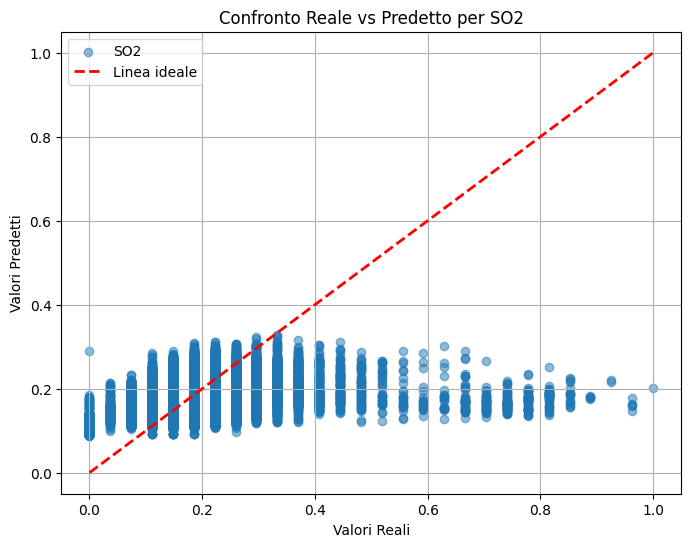


Lavorando su: NO2
                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                 6.847e+04
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:36:48   Log-Likelihood:             8.9478e+05
No. Observations:              510137   AIC:                        -1.790e+06
Df Residuals:                  510126   BIC:                        -1.789e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -694.5823     2

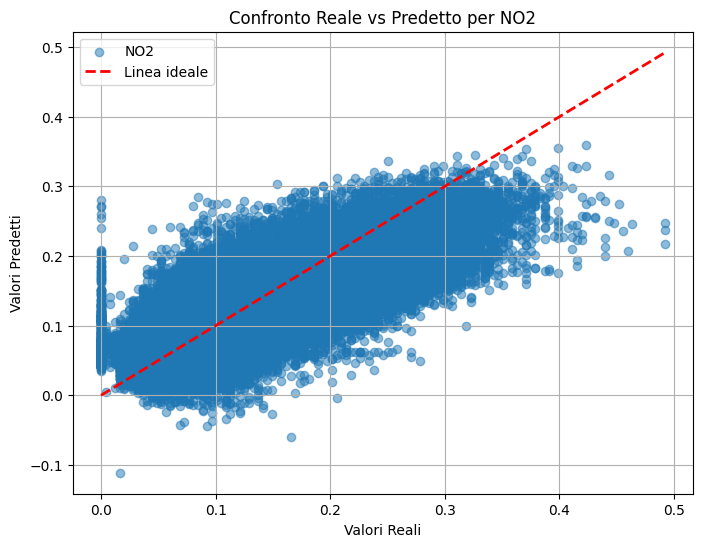


Lavorando su: CO
                            OLS Regression Results                            
Dep. Variable:                     CO   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                 7.060e+04
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:36:50   Log-Likelihood:             4.6683e+05
No. Observations:              510137   AIC:                        -9.336e+05
Df Residuals:                  510126   BIC:                        -9.335e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2212.4979     65

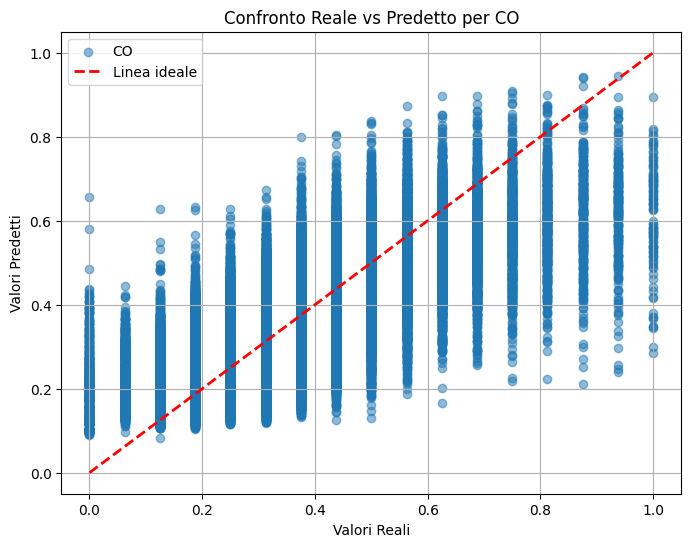


Lavorando su: O3
                            OLS Regression Results                            
Dep. Variable:                     O3   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                 3.460e+04
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:36:52   Log-Likelihood:             5.8517e+05
No. Observations:              510137   AIC:                        -1.170e+06
Df Residuals:                  510126   BIC:                        -1.170e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2260.4471     52

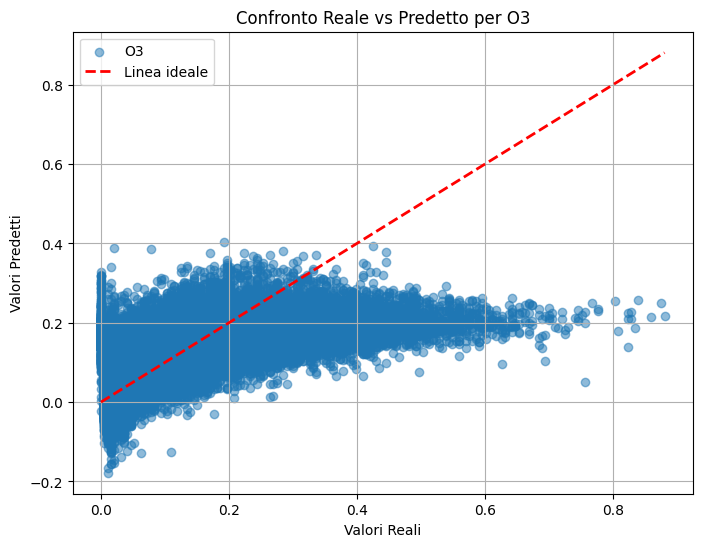


Lavorando su: PM10
                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                 1.256e+05
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:36:53   Log-Likelihood:             7.1972e+05
No. Observations:              510137   AIC:                        -1.439e+06
Df Residuals:                  510126   BIC:                        -1.439e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1404.5935     

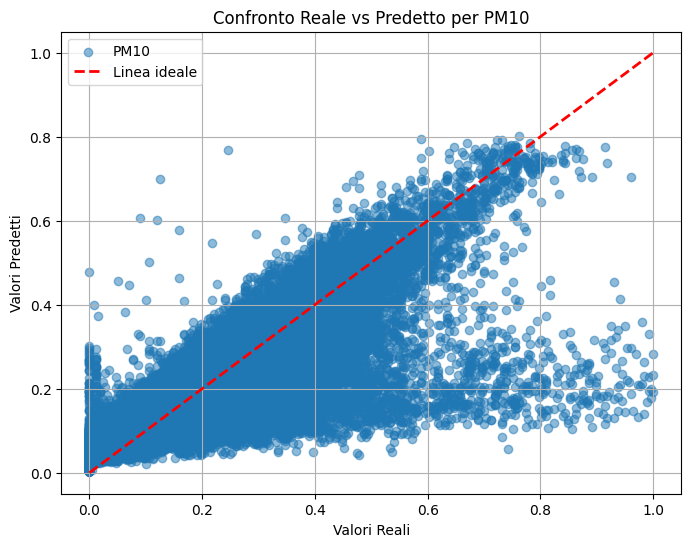


Lavorando su: PM2.5
                            OLS Regression Results                            
Dep. Variable:                  PM2.5   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                 1.404e+05
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:36:54   Log-Likelihood:             7.0429e+05
No. Observations:              510137   AIC:                        -1.409e+06
Df Residuals:                  510126   BIC:                        -1.408e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -620.3973    

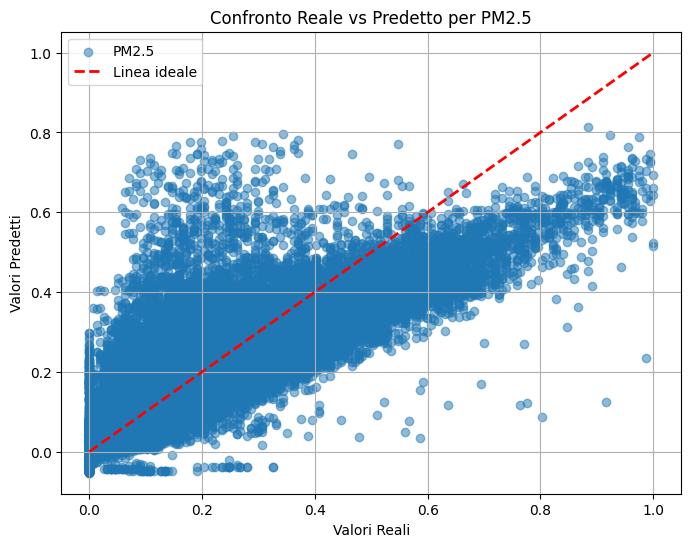



Risultati complessivi:
SO2: MSE=0.0035, R^2=0.1623
NO2: MSE=0.0017, R^2=0.5982
CO: MSE=0.0077, R^2=0.6037
O3: MSE=0.0055, R^2=0.4319
PM10: MSE=0.0042, R^2=0.6847
PM2.5: MSE=0.0042, R^2=0.7177


In [12]:
df_norm = df_norm_originale.copy(deep=True)
#print(df_norm)
# Codifico la data come caratteristiche numeriche
df_norm['Day_of_year'] = df_norm['Measurement date'].dt.dayofyear
df_norm['Year'] = df_norm['Measurement date'].dt.year
df_norm['Month'] = df_norm['Measurement date'].dt.month

# Normalizzo le variabili temporali
scaler = MinMaxScaler()
df_norm[['Day_of_year', 'Year', 'Month']] = scaler.fit_transform(df_norm[['Day_of_year', 'Year', 'Month']])

# Converto Station code in categoria
df_norm['Station code'] = df_norm['Station code'].astype('category').cat.codes

# Aggiungo trasformazioni cicliche
df_norm['sin_day'] = np.sin(2 * np.pi * df_norm['Day_of_year'] / 365)
df_norm['cos_day'] = np.cos(2 * np.pi * df_norm['Day_of_year'] / 365)
df_norm['sin_month'] = np.sin(2 * np.pi * df_norm['Month'] / 12)
df_norm['cos_month'] = np.cos(2 * np.pi * df_norm['Month'] / 12)

# Risultati da salvare
result_dict = {}

for inquinante in inquinanti:
    print(f"\nLavorando su: {inquinante}")
    
    # Creo una lista di altri inquinanti, escludendo quello corrente
    altri_inquinanti = [altro for altro in inquinanti if altro != inquinante]
    
    # Preparo i dati includendo gli inquinanti correlati
    columns = ['sin_day', 'cos_day', 'sin_month', 'cos_month', 'Station code'] + altri_inquinanti + [inquinante]
    data = df_norm[columns].dropna()

    X = data[['sin_day', 'cos_day', 'sin_month', 'cos_month', 'Station code'] + altri_inquinanti]
    y = data[inquinante]
    
    # Aggiungo un termine di bias (intercept) a X
    X = sm.add_constant(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= False)
    
    # Modello di regressione lineare con statsmodels
    model = sm.OLS(y_train, X_train).fit()
    
    # Stampo il sommario del modello
    print(model.summary())
    
    # Predizione sui dati di test
    y_pred = model.predict(X_test)
    
    # Calcolo delle metriche
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    result_dict[inquinante] = {'mse': mse, 'r2': r2}
    
    # Confronto valori reali vs predetti
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label=f'{inquinante}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Linea ideale')
    plt.xlabel("Valori Reali")
    plt.ylabel("Valori Predetti")
    plt.title(f"Confronto Reale vs Predetto per {inquinante}")
    plt.legend()
    plt.grid()
    plt.show()
    
    '''
    # Visualizzazione dell'errore residuo
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test - y_pred, alpha=0.5, label=f'{inquinante}')
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel("Valori Reali")
    plt.ylabel("Errore Residuo")
    plt.title(f"Errore Residuo per {inquinante}")
    plt.legend()
    plt.grid()
    plt.show()
    '''

# Risultati finali
print("\n\nRisultati complessivi:")
for inquinante, metrics in result_dict.items():
    print(f"{inquinante}: MSE={metrics['mse']:.4f}, R^2={metrics['r2']:.4f}")

Linear regression con mse e r^2 per le categorie "buono", "Normale", "Cattivo", "Molto Cattivo"


Lavorando su: SO2
{'Item code': 1, 'Item name': 'SO2', 'Unit of measurement': 'ppm', 'Good(Blue)': 0.02, 'Normal(Green)': 0.05, 'Bad(Yellow)': 0.15, 'Very bad(Red)': 1.0}
                            OLS Regression Results                            
Dep. Variable:                    SO2   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                 1.711e+04
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:40:06   Log-Likelihood:             7.3477e+05
No. Observations:              510137   AIC:                        -1.470e+06
Df Residuals:                  510127   BIC:                        -1.469e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err    

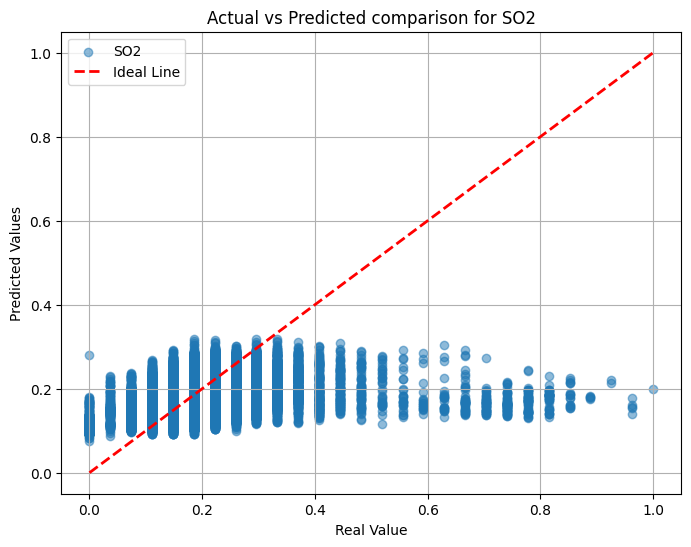


Lavorando su: NO2
{'Item code': 3, 'Item name': 'NO2', 'Unit of measurement': 'ppm', 'Good(Blue)': 0.03, 'Normal(Green)': 0.06, 'Bad(Yellow)': 0.2, 'Very bad(Red)': 2.0}
                            OLS Regression Results                            
Dep. Variable:                    NO2   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                 7.521e+04
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:40:08   Log-Likelihood:             8.9312e+05
No. Observations:              510137   AIC:                        -1.786e+06
Df Residuals:                  510127   BIC:                        -1.786e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err     

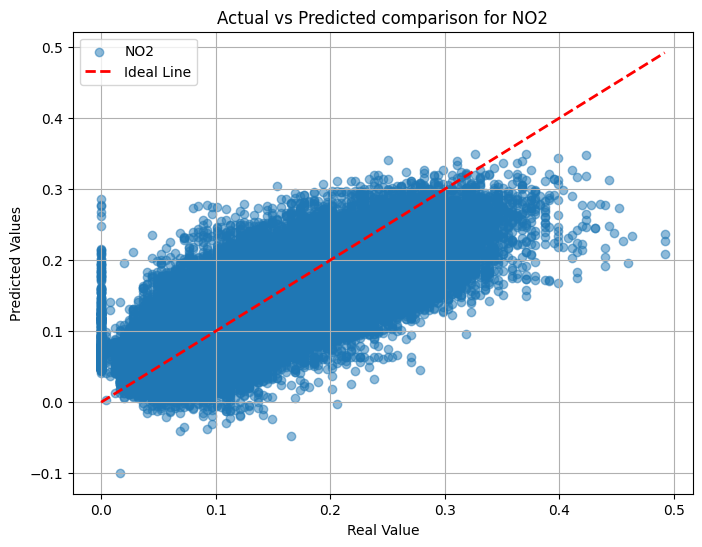


Lavorando su: CO
{'Item code': 5, 'Item name': 'CO', 'Unit of measurement': 'ppm', 'Good(Blue)': 2.0, 'Normal(Green)': 9.0, 'Bad(Yellow)': 15.0, 'Very bad(Red)': 50.0}
                            OLS Regression Results                            
Dep. Variable:                     CO   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                 7.237e+04
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:40:10   Log-Likelihood:             4.5511e+05
No. Observations:              510137   AIC:                        -9.102e+05
Df Residuals:                  510127   BIC:                        -9.101e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err       

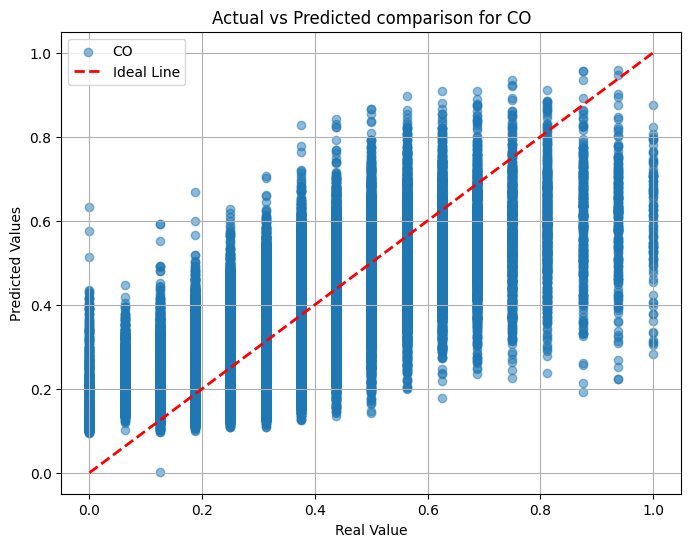


Lavorando su: O3
{'Item code': 6, 'Item name': 'O3', 'Unit of measurement': 'ppm', 'Good(Blue)': 0.03, 'Normal(Green)': 0.09, 'Bad(Yellow)': 0.15, 'Very bad(Red)': 0.5}
                            OLS Regression Results                            
Dep. Variable:                     O3   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                 2.664e+04
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:40:11   Log-Likelihood:             5.5137e+05
No. Observations:              510137   AIC:                        -1.103e+06
Df Residuals:                  510127   BIC:                        -1.103e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err      

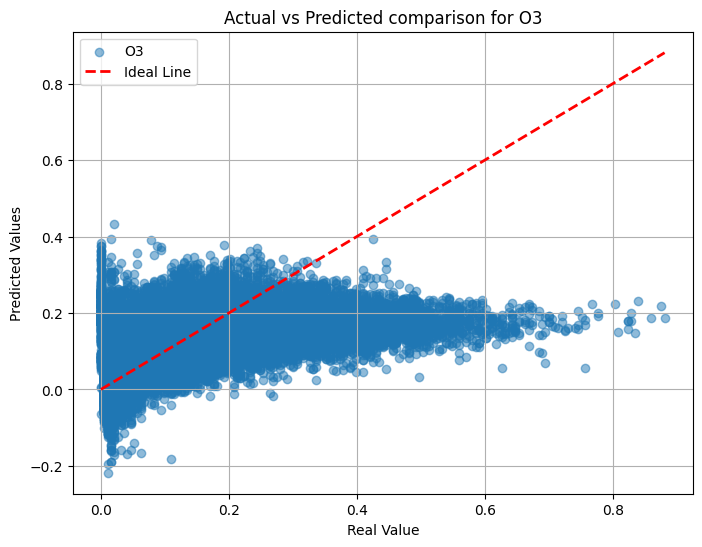


Lavorando su: PM10
{'Item code': 8, 'Item name': 'PM10', 'Unit of measurement': 'Mircrogram/m3', 'Good(Blue)': 30.0, 'Normal(Green)': 80.0, 'Bad(Yellow)': 150.0, 'Very bad(Red)': 600.0}
                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                 1.370e+05
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:40:13   Log-Likelihood:             7.1642e+05
No. Observations:              510137   AIC:                        -1.433e+06
Df Residuals:                  510127   BIC:                        -1.433e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef

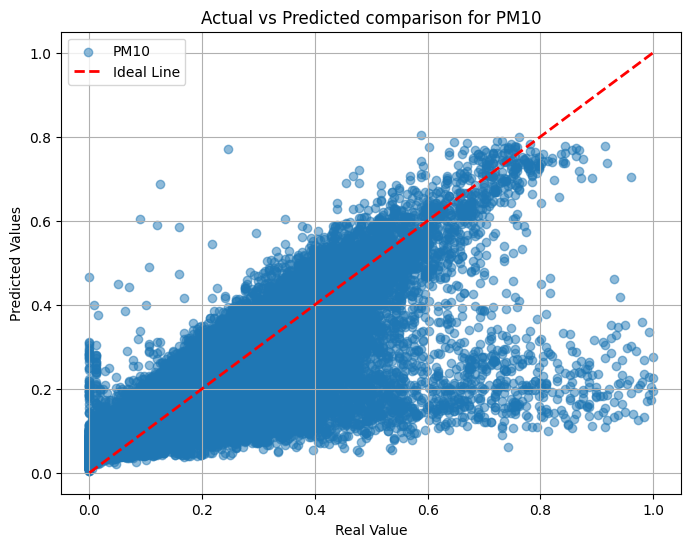


Lavorando su: PM2.5
{'Item code': 9, 'Item name': 'PM2.5', 'Unit of measurement': 'Mircrogram/m3', 'Good(Blue)': 15.0, 'Normal(Green)': 35.0, 'Bad(Yellow)': 75.0, 'Very bad(Red)': 500.0}
                            OLS Regression Results                            
Dep. Variable:                  PM2.5   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                 1.557e+05
Date:                Sat, 25 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:40:14   Log-Likelihood:             7.0400e+05
No. Observations:              510137   AIC:                        -1.408e+06
Df Residuals:                  510127   BIC:                        -1.408e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coe

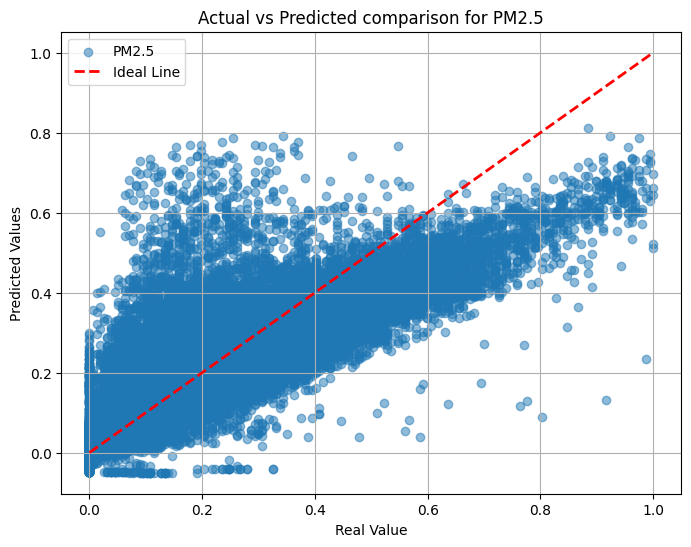



Overall results:
SO2: MSE=0.0034, R^2=0.1771
Error by category:
  - Good: MSE=0.0030
  - Normal: MSE=0.4135
  - Bad: MSE=nan
  - Very Bad: MSE=nan
NO2: MSE=0.0018, R^2=0.5881
Error by category:
  - Good: MSE=0.0010
  - Normal: MSE=0.0022
  - Bad: MSE=0.0074
  - Very Bad: MSE=nan
CO: MSE=0.0083, R^2=0.5764
Error by category:
  - Good: MSE=0.0083
  - Normal: MSE=nan
  - Bad: MSE=nan
  - Very Bad: MSE=nan
O3: MSE=0.0063, R^2=0.3459
Error by category:
  - Good: MSE=0.0034
  - Normal: MSE=0.0110
  - Bad: MSE=0.1422
  - Very Bad: MSE=0.4225
PM10: MSE=0.0042, R^2=0.6830
Error by category:
  - Good: MSE=0.0013
  - Normal: MSE=0.0022
  - Bad: MSE=0.0155
  - Very Bad: MSE=0.1353
PM2.5: MSE=0.0042, R^2=0.7194
Error by category:
  - Good: MSE=0.0021
  - Normal: MSE=0.0033
  - Bad: MSE=0.0066
  - Very Bad: MSE=0.0326


In [13]:
df_norm = df_norm_originale.copy(deep=True)

# Codifico la data come caratteristiche numeriche (esempio: giorno dell'anno, anno, mese)
df_norm['Day_of_year'] = df_norm['Measurement date'].dt.dayofyear
df_norm['Year'] = df_norm['Measurement date'].dt.year
df_norm['Month'] = df_norm['Measurement date'].dt.month

# Converto Station code, Day_of_year, Year, Month in categorie
df_norm['Station code'] = df_norm['Station code'].astype('category').cat.codes
df_norm['Day_of_year'] = df_norm['Day_of_year'].astype('category').cat.codes
df_norm['Year'] = df_norm['Year'].astype('category').cat.codes
df_norm['Month'] = df_norm['Month'].astype('category').cat.codes

# Dizionario per salvare i risultati
result_dict = {}

for inquinante in inquinanti:
    print(f"\nLavorando su: {inquinante}")
    
    # Estraggo le soglie per l'inquinante corrente
    thresholds = Measurement_item_info[Measurement_item_info['Item name'] == inquinante].iloc[0].to_dict()
    print(thresholds)

    # Recupero i valori minimi e massimi per l'inquinante corrente
    min_value = Measurement_summary[inquinante].min()
    max_value = Measurement_summary[inquinante].max()

    # Normalizzo le soglie in base a questi minimi e massimi
    normalized_thresholds_dict = {}
    for key in ['Good(Blue)', 'Normal(Green)', 'Bad(Yellow)', 'Very bad(Red)']:
        # Prendi il valore della soglia, normalizzalo usando il MinMaxScaler
        normalized_value = (thresholds[key] - min_value) / (max_value - min_value)
        normalized_thresholds_dict[key] = normalized_value

    # Creo una lista di altri inquinanti, escludendo quello corrente
    altri_inquinanti = [altro for altro in inquinanti if altro != inquinante]
    
    # Preparo i dati
    columns = ['Day_of_year', 'Year', 'Month', 'Station code'] + altri_inquinanti + [inquinante]
    data = df_norm[columns].dropna()  # Rimuovo le righe con valori mancanti
    X = data[['Day_of_year', 'Year', 'Month', 'Station code'] + altri_inquinanti]
    y = data[inquinante]
    
    # Aggiungo un termine di bias (intercept) a X
    X = sm.add_constant(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= False)
    
    # Modello di regressione lineare con statsmodels
    model = sm.OLS(y_train, X_train).fit()
    
    # Stampo il sommario del modello
    print(model.summary())
    
    # Predizione sui dati di test
    y_pred = model.predict(X_test)
    
    # Calcolo delle metriche di valutazione generali
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Funzione di classificazione aggiornata per utilizzare le soglie normalizzate
    def classify_concentration_new(value, thresholds):
        if value <= thresholds['Good(Blue)']:
            return 'Good'
        elif value <= thresholds['Normal(Green)']:
            return 'Normal'
        elif value <= thresholds['Bad(Yellow)']:
            return 'Bad'
        else:
            return 'Very Bad'

    # Classifico i valori reali e predetti nelle categorie
    y_test_categories = y_test.apply(classify_concentration_new, thresholds=normalized_thresholds_dict)
    y_pred_categories = pd.Series([classify_concentration_new(val, normalized_thresholds_dict) for val in y_pred], index=y_test.index)

    # Calcolo l'errore per ciascuna categoria
    errors_by_category = {}
    for category in ['Good', 'Normal', 'Bad', 'Very Bad']:
        # Filtro dei dati per categoria
        category_indices = y_test_categories == category
        category_y_test = y_test[category_indices]
        category_y_pred = y_pred[category_indices]
        
        if len(category_y_test) > 0:
            mse_category = mean_squared_error(category_y_test, category_y_pred)
            errors_by_category[category] = mse_category
        else:
            errors_by_category[category] = np.nan  # Se non ci sono dati per quella categoria, assegno NaN

    result_dict[inquinante] = {'mse': mse, 'r2': r2, 'category_errors': errors_by_category}
    
    # Confronto valori reali vs predetti
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label=f'{inquinante}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Line')
    plt.xlabel("Real Value")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted comparison for {inquinante}")
    plt.legend()
    plt.grid()
    plt.show()

# Risultati finali
print("\n\nOverall results:")
for inquinante, metrics in result_dict.items():
    print(f"{inquinante}: MSE={metrics['mse']:.4f}, R^2={metrics['r2']:.4f}")
    print("Error by category:")
    for category, error in metrics['category_errors'].items():
        print(f"  - {category}: MSE={error:.4f}")

Printiamo i grafici utilizzando subplot

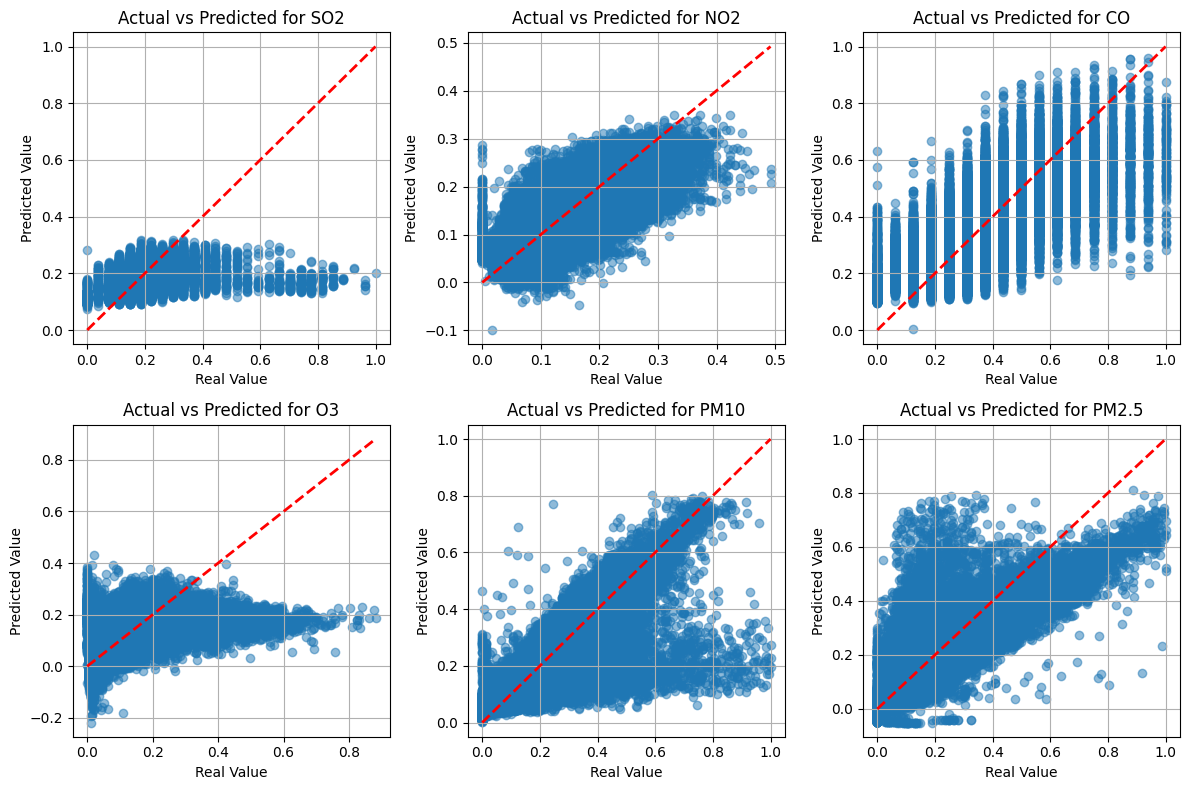

In [14]:
df_norm = df_norm_originale.copy(deep=True)

# Codifico la data come caratteristiche numeriche (esempio: giorno dell'anno, anno, mese)
df_norm['Day_of_year'] = df_norm['Measurement date'].dt.dayofyear
df_norm['Year'] = df_norm['Measurement date'].dt.year
df_norm['Month'] = df_norm['Measurement date'].dt.month

# Converto Station code, Day_of_year, Year, Month in categorie
df_norm['Station code'] = df_norm['Station code'].astype('category').cat.codes
df_norm['Day_of_year'] = df_norm['Day_of_year'].astype('category').cat.codes
df_norm['Year'] = df_norm['Year'].astype('category').cat.codes
df_norm['Month'] = df_norm['Month'].astype('category').cat.codes

# Imposto il numero di colonne per i subplot
num_cols = 3
num_rows = (len(inquinanti) + 1) // num_cols  # Calcolo il numero di righe necessarie

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten() 

for i, inquinante in enumerate(inquinanti):
    # Recupero i dati e calcolo le previsioni (come nel codice fornito)
    
    # Estraggo le soglie per l'inquinante corrente
    thresholds = Measurement_item_info[Measurement_item_info['Item name'] == inquinante].iloc[0].to_dict()

    # Normalizzo le soglie
    min_value = Measurement_summary[inquinante].min()
    max_value = Measurement_summary[inquinante].max()
    normalized_thresholds_dict = {key: (thresholds[key] - min_value) / (max_value - min_value) for key in ['Good(Blue)', 'Normal(Green)', 'Bad(Yellow)', 'Very bad(Red)']}

    # Preparo i dati
    columns = ['Day_of_year', 'Year', 'Month', 'Station code'] + [altro for altro in inquinanti if altro != inquinante] + [inquinante]
    data = df_norm[columns].dropna()
    X = data[['Day_of_year', 'Year', 'Month', 'Station code'] + [altro for altro in inquinanti if altro != inquinante]]
    y = data[inquinante]
    
    # Aggiungo un termine di bias (intercept) a X
    X = sm.add_constant(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False)
    
    # Modello di regressione lineare
    model = sm.OLS(y_train, X_train).fit()
    
    # Predizione sui dati di test
    y_pred = model.predict(X_test)
    
    # Scatter plot sui subplot
    axes[i].scatter(y_test, y_pred, alpha=0.5)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[i].set_title(f'Actual vs Predicted for {inquinante}')
    axes[i].set_xlabel('Real Value')
    axes[i].set_ylabel('Predicted Value')
    axes[i].grid()

# Nascondo gli assi inutilizzati se il numero di inquinanti non è pari al numero di subplot
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

FORECASTING. Utilizziamo la cross validation per trovare il "lag" che minimizza gli errori


Evaluating lag_range = 1...
lag_range = 1, Mean MSE = 0.0013036064690766214

Evaluating lag_range = 2...
lag_range = 2, Mean MSE = 0.0012412170996094496

Evaluating lag_range = 3...
lag_range = 3, Mean MSE = 0.0012346067426718416

Evaluating lag_range = 4...
lag_range = 4, Mean MSE = 0.0012300010397946117

Evaluating lag_range = 5...
lag_range = 5, Mean MSE = 0.0012293062292864265

Evaluating lag_range = 6...
lag_range = 6, Mean MSE = 0.0012260330571930334

Evaluating lag_range = 7...
lag_range = 7, Mean MSE = 0.001225401525918195

Evaluating lag_range = 8...
lag_range = 8, Mean MSE = 0.0012232246973718872

Evaluating lag_range = 9...
lag_range = 9, Mean MSE = 0.0012233168009328497

Evaluating lag_range = 10...
lag_range = 10, Mean MSE = 0.0012232070012782232

Evaluating lag_range = 11...
lag_range = 11, Mean MSE = 0.0012235485874603582

Evaluating lag_range = 12...
lag_range = 12, Mean MSE = 0.0012225991158497733

Evaluating lag_range = 13...
lag_range = 13, Mean MSE = 0.001221535990

C:\Users\vince\AppData\Local\Temp\ipykernel_8196\3492289701.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{pollutant}_lag_{lag}'] = data[pollutant].shift(lag)


lag_range = 16, Mean MSE = 0.0012178649956312427

Best lag_range: 16 with Mean MSE = 0.0012178649956312427


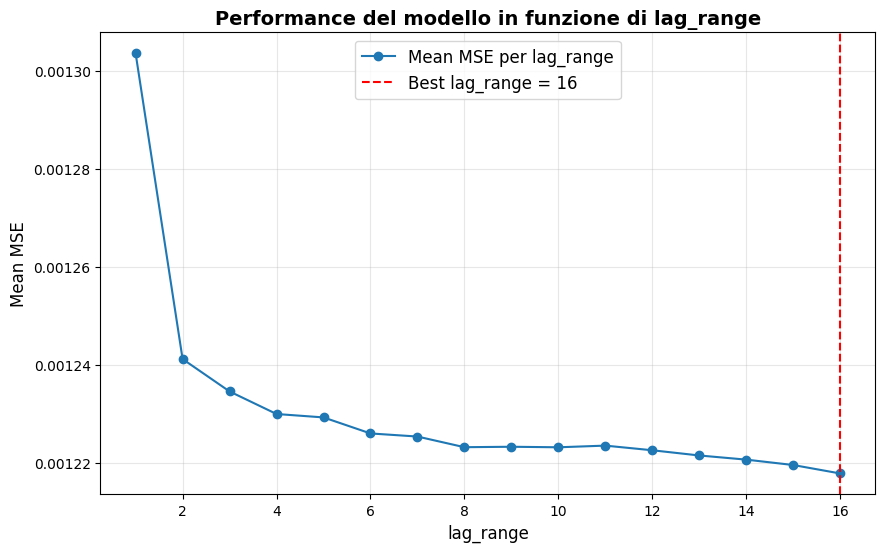

In [15]:
data = df_norm_originale.copy(deep=True)

# Aggiungo caratteristiche temporali
data['year'] = data['Measurement date'].dt.year
data['month'] = data['Measurement date'].dt.month
data['day'] = data['Measurement date'].dt.day
data['hour'] = data['Measurement date'].dt.hour
data['day_of_week'] = data['Measurement date'].dt.dayofweek

# Converto Station code in una variabile categoriale
data['Station code'] = data['Station code'].astype('category').cat.codes

# Funzione per generare lag features dinamicamente
def create_lagged_features(data, pollutants, lag_range):
    for pollutant in pollutants:
        for lag in range(1, lag_range + 1):
            data[f'{pollutant}_lag_{lag}'] = data[pollutant].shift(lag)
    return data.dropna()

# Funzione per Cross Validation
def evaluate_model_with_cv(data, pollutants, max_lag_range, target_pollutant, time_features, station_feature):
    best_mse = float('inf')
    best_lag_range = None
    results = {}

    for lag_range in range(1, max_lag_range + 1):
        print(f"\nEvaluating lag_range = {lag_range}...")

        # Creo lag features dinamicamente
        lagged_data = create_lagged_features(data.copy(), pollutants, lag_range)

        # Features e target
        lag_features = [f'{p}_lag_{l}' for p in pollutants for l in range(1, lag_range + 1)]
        features = lag_features + time_features + station_feature
        X = lagged_data[features]
        y = lagged_data[target_pollutant]

        # Definizione del TimeSeriesSplit per CV
        tscv = TimeSeriesSplit(n_splits=5)

        # Modello
        model = LinearRegression()

        # Metrica per la CV
        scorer = make_scorer(mean_squared_error, greater_is_better=False)

        # Eseguo Cross Validation
        scores = cross_val_score(model, X, y, cv=tscv, scoring=scorer)
        mean_mse = -np.mean(scores)

        # Salvo i risultati
        results[lag_range] = mean_mse
        print(f"lag_range = {lag_range}, Mean MSE = {mean_mse}")

        # Aggiorno il miglior lag_range
        if mean_mse < best_mse:
            best_mse = mean_mse
            best_lag_range = lag_range

    print(f"\nBest lag_range: {best_lag_range} with Mean MSE = {best_mse}")
    return best_lag_range, results

# Parametri
max_lag_range = 16 # Numero massimo di lag da testare (dopo si ottengono warning a causa dell'alta frammentazione)
time_features = ['year', 'month', 'day', 'hour', 'day_of_week']
station_feature = ['Station code']
target_pollutant = 'PM2.5'  # Sceglo l'inquinante target per ottimizzare lag_range

# Trovoil miglior lag_range
best_lag_range, cv_results = evaluate_model_with_cv(data, inquinanti, max_lag_range, target_pollutant, time_features, station_feature)

# Visualizzo i risultati della CV
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(cv_results.keys(), cv_results.values(), marker='o', label='Mean MSE per lag_range')
plt.axvline(best_lag_range, color='red', linestyle='--', label=f'Best lag_range = {best_lag_range}')
plt.title("Performance del modello in funzione di lag_range", fontsize=14, fontweight='bold')
plt.xlabel("lag_range", fontsize=12)
plt.ylabel("Mean MSE", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

Modifichiamo regressione lineare tenendo conto che i dati a disposizione rappresentano una serie temporale


Training model for SO2...
{'Item code': 1, 'Item name': 'SO2', 'Unit of measurement': 'ppm', 'Good(Blue)': 0.02, 'Normal(Green)': 0.05, 'Bad(Yellow)': 0.15, 'Very bad(Red)': 1.0}
SO2 - Mean Squared Error: 0.0006090135442222972
SO2 - R^2 Score: 0.8473495826544719


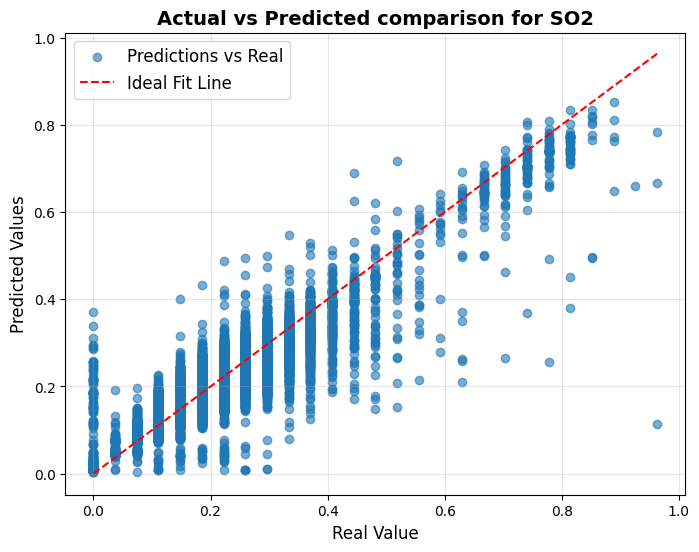


Training model for NO2...
{'Item code': 3, 'Item name': 'NO2', 'Unit of measurement': 'ppm', 'Good(Blue)': 0.03, 'Normal(Green)': 0.06, 'Bad(Yellow)': 0.2, 'Very bad(Red)': 2.0}
NO2 - Mean Squared Error: 0.00047896532022496284
NO2 - R^2 Score: 0.8874139766437941


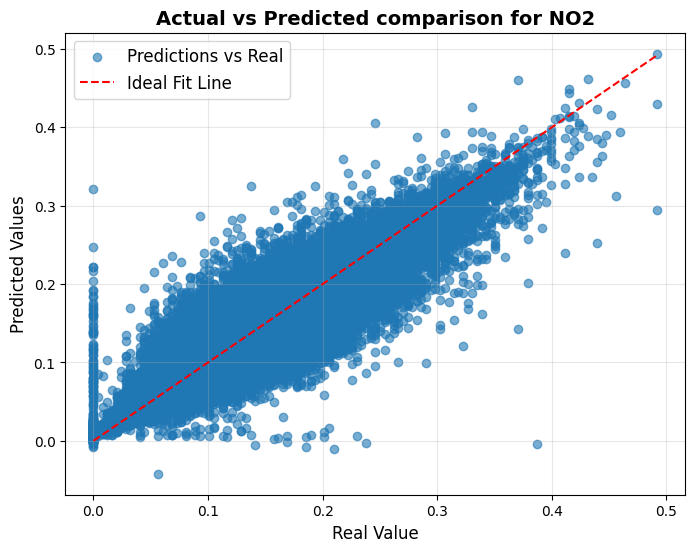


Training model for CO...
{'Item code': 5, 'Item name': 'CO', 'Unit of measurement': 'ppm', 'Good(Blue)': 2.0, 'Normal(Green)': 9.0, 'Bad(Yellow)': 15.0, 'Very bad(Red)': 50.0}
CO - Mean Squared Error: 0.002413883383418296
CO - R^2 Score: 0.8706877432752811


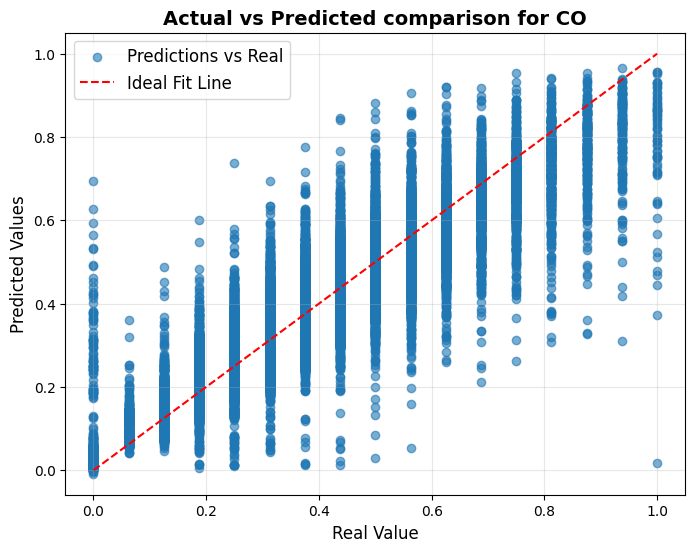


Training model for O3...
{'Item code': 6, 'Item name': 'O3', 'Unit of measurement': 'ppm', 'Good(Blue)': 0.03, 'Normal(Green)': 0.09, 'Bad(Yellow)': 0.15, 'Very bad(Red)': 0.5}
O3 - Mean Squared Error: 0.0008320799986966538
O3 - R^2 Score: 0.9140130371010654


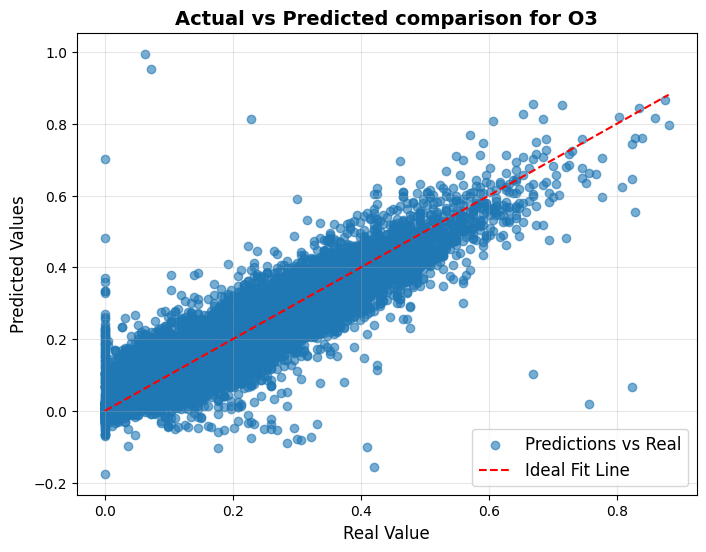


Training model for PM10...
{'Item code': 8, 'Item name': 'PM10', 'Unit of measurement': 'Mircrogram/m3', 'Good(Blue)': 30.0, 'Normal(Green)': 80.0, 'Bad(Yellow)': 150.0, 'Very bad(Red)': 600.0}
PM10 - Mean Squared Error: 0.0012153986543149088
PM10 - R^2 Score: 0.9005240001934295


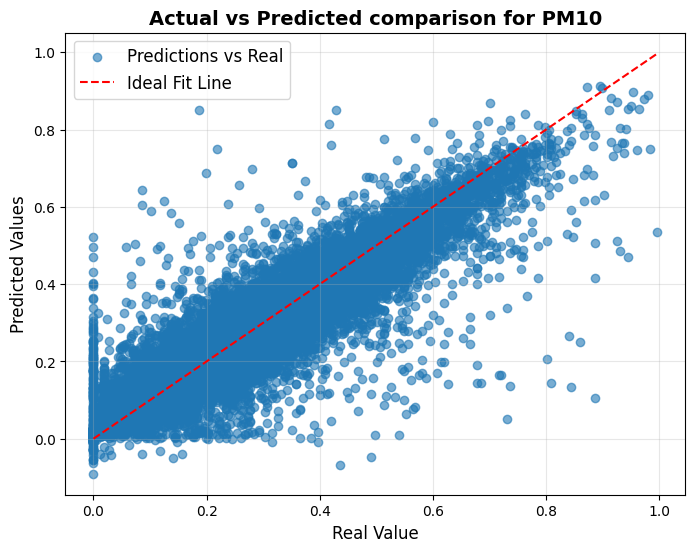


Training model for PM2.5...
{'Item code': 9, 'Item name': 'PM2.5', 'Unit of measurement': 'Mircrogram/m3', 'Good(Blue)': 15.0, 'Normal(Green)': 35.0, 'Bad(Yellow)': 75.0, 'Very bad(Red)': 500.0}
PM2.5 - Mean Squared Error: 0.0013742575724963572
PM2.5 - R^2 Score: 0.903210731494702


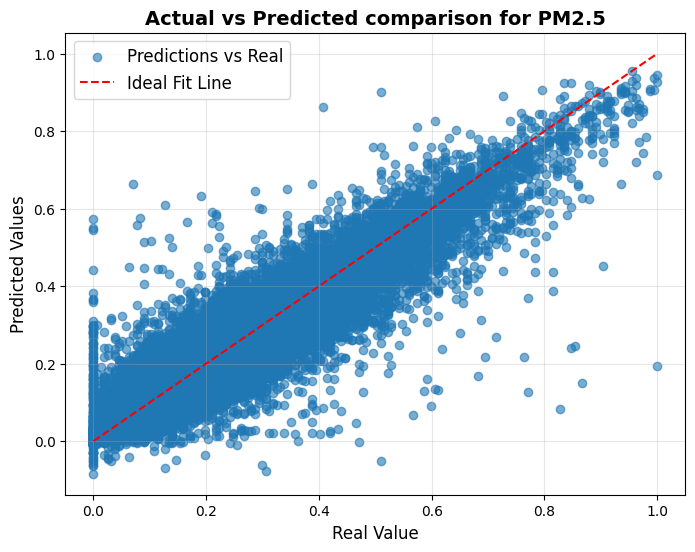



Overall results:
SO2: MSE=0.0006, R^2=0.8473
Error by category:
  - Good: MSE=0.0006
  - Normal: MSE=0.0208
  - Bad: MSE=nan
  - Very Bad: MSE=nan
NO2: MSE=0.0005, R^2=0.8874
Error by category:
  - Good: MSE=0.0003
  - Normal: MSE=0.0006
  - Bad: MSE=0.0012
  - Very Bad: MSE=nan
CO: MSE=0.0024, R^2=0.8707
Error by category:
  - Good: MSE=0.0024
  - Normal: MSE=nan
  - Bad: MSE=nan
  - Very Bad: MSE=nan
O3: MSE=0.0008, R^2=0.9140
Error by category:
  - Good: MSE=0.0006
  - Normal: MSE=0.0013
  - Bad: MSE=0.0067
  - Very Bad: MSE=0.0618
PM10: MSE=0.0012, R^2=0.9005
Error by category:
  - Good: MSE=0.0006
  - Normal: MSE=0.0010
  - Bad: MSE=0.0038
  - Very Bad: MSE=0.0193
PM2.5: MSE=0.0014, R^2=0.9032
Error by category:
  - Good: MSE=0.0007
  - Normal: MSE=0.0010
  - Bad: MSE=0.0027
  - Very Bad: MSE=0.0090


In [16]:
data = df_norm_originale.copy(deep=True)

# Aggiungo caratteristiche temporali
data['year'] = data['Measurement date'].dt.year
data['month'] = data['Measurement date'].dt.month
data['day'] = data['Measurement date'].dt.day
data['hour'] = data['Measurement date'].dt.hour
data['day_of_week'] = data['Measurement date'].dt.dayofweek

# Converto Station code in una variabile categoriale
data['Station code'] = data['Station code'].astype('category').cat.codes

# Dizionario per salvare i risultati
result_dict = {}

# Creo lag features per tutti gli inquinanti
lag_range = 10  # Numero di lag (non è il migliore trovato sopra ma è ottimo compromesso tra riduzione errore e velocità di esecuzione)
for inquinante in inquinanti:
    for lag in range(1, lag_range + 1):
        data[f'{inquinante}_lag_{lag}'] = data[inquinante].shift(lag)

# Rimuovo righe con valori NaN generati dai lag
data = data.dropna()

# Modello per ogni inquinante
results = {}
for inquinante in inquinanti:
    print(f"\nTraining model for {inquinante}...")
    
    # Estraggo le soglie per l'inquinante corrente
    thresholds = Measurement_item_info[Measurement_item_info['Item name'] == inquinante].iloc[0].to_dict()
    print(thresholds)

    # Recupero i valori minimi e massimi per l'inquinante corrente
    min_value = Measurement_summary[inquinante].min()
    max_value = Measurement_summary[inquinante].max()

    # Normalizzo le soglie in base a questi minimi e massimi
    normalized_thresholds_dict = {}
    for key in ['Good(Blue)', 'Normal(Green)', 'Bad(Yellow)', 'Very bad(Red)']:
        # Prendo il valore della soglia e normalizzo usando il MinMaxScaler
        normalized_value = (thresholds[key] - min_value) / (max_value - min_value)
        normalized_thresholds_dict[key] = normalized_value

    # Caratteristiche
    lag_features = [f'{p}_lag_{l}' for p in inquinanti for l in range(1, lag_range + 1)]
    time_features = ['year', 'month', 'day', 'hour', 'day_of_week']
    station_feature = ['Station code']
    features = lag_features + time_features + station_feature

    X = data[features]
    y = data[inquinante]

    # Divido in training e test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Modello di regressione lineare
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Valutazione
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[inquinante] = {'model': model, 'mse': mse, 'r2': r2, 'y_test': y_test, 'y_pred': y_pred}

    print(f"{inquinante} - Mean Squared Error: {mse}")
    print(f"{inquinante} - R^2 Score: {r2}")
    
    # Funzione di classificazione aggiornata per utilizzare le soglie normalizzate
    def classify_concentration_new(value, thresholds):
        if value <= thresholds['Good(Blue)']:
            return 'Good'
        elif value <= thresholds['Normal(Green)']:
            return 'Normal'
        elif value <= thresholds['Bad(Yellow)']:
            return 'Bad'
        else:
            return 'Very Bad'

    # Classifico i valori reali e predetti nelle categorie
    y_test_categories = y_test.apply(classify_concentration_new, thresholds=normalized_thresholds_dict)
    y_pred_categories = pd.Series([classify_concentration_new(val, normalized_thresholds_dict) for val in y_pred], index=y_test.index)

    # Calcolo l'errore per ciascuna categoria
    errors_by_category = {}
    for category in ['Good', 'Normal', 'Bad', 'Very Bad']:
        # Filtro dei dati per categoria
        category_indices = y_test_categories == category
        category_y_test = y_test[category_indices]
        category_y_pred = y_pred[category_indices]
        
        if len(category_y_test) > 0:
            mse_category = mean_squared_error(category_y_test, category_y_pred)
            errors_by_category[category] = mse_category
        else:
            errors_by_category[category] = np.nan  # Se non ci sono dati per quella categoria, assegna NaN

    result_dict[inquinante] = {'mse': mse, 'r2': r2, 'category_errors': errors_by_category}

    # Grafico per Y Predette vs Y Vere
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label='Predictions vs Real')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit Line')
    plt.title(f"Actual vs Predicted comparison for {inquinante}", fontsize=14, fontweight='bold')
    plt.xlabel("Real Value", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Risultati finali
print("\n\nOverall results:")
for inquinante, metrics in result_dict.items():
    print(f"{inquinante}: MSE={metrics['mse']:.4f}, R^2={metrics['r2']:.4f}")
    print("Error by category:")
    for category, error in metrics['category_errors'].items():
        print(f"  - {category}: MSE={error:.4f}")

Con i subplot


Training model for SO2...
SO2 - Mean Squared Error: 0.0006090135442222972
SO2 - R^2 Score: 0.8473495826544719

Training model for NO2...
NO2 - Mean Squared Error: 0.00047896532022496284
NO2 - R^2 Score: 0.8874139766437941

Training model for CO...
CO - Mean Squared Error: 0.002413883383418296
CO - R^2 Score: 0.8706877432752811

Training model for O3...
O3 - Mean Squared Error: 0.0008320799986966538
O3 - R^2 Score: 0.9140130371010654

Training model for PM10...
PM10 - Mean Squared Error: 0.0012153986543149088
PM10 - R^2 Score: 0.9005240001934295

Training model for PM2.5...
PM2.5 - Mean Squared Error: 0.0013742575724963572
PM2.5 - R^2 Score: 0.903210731494702


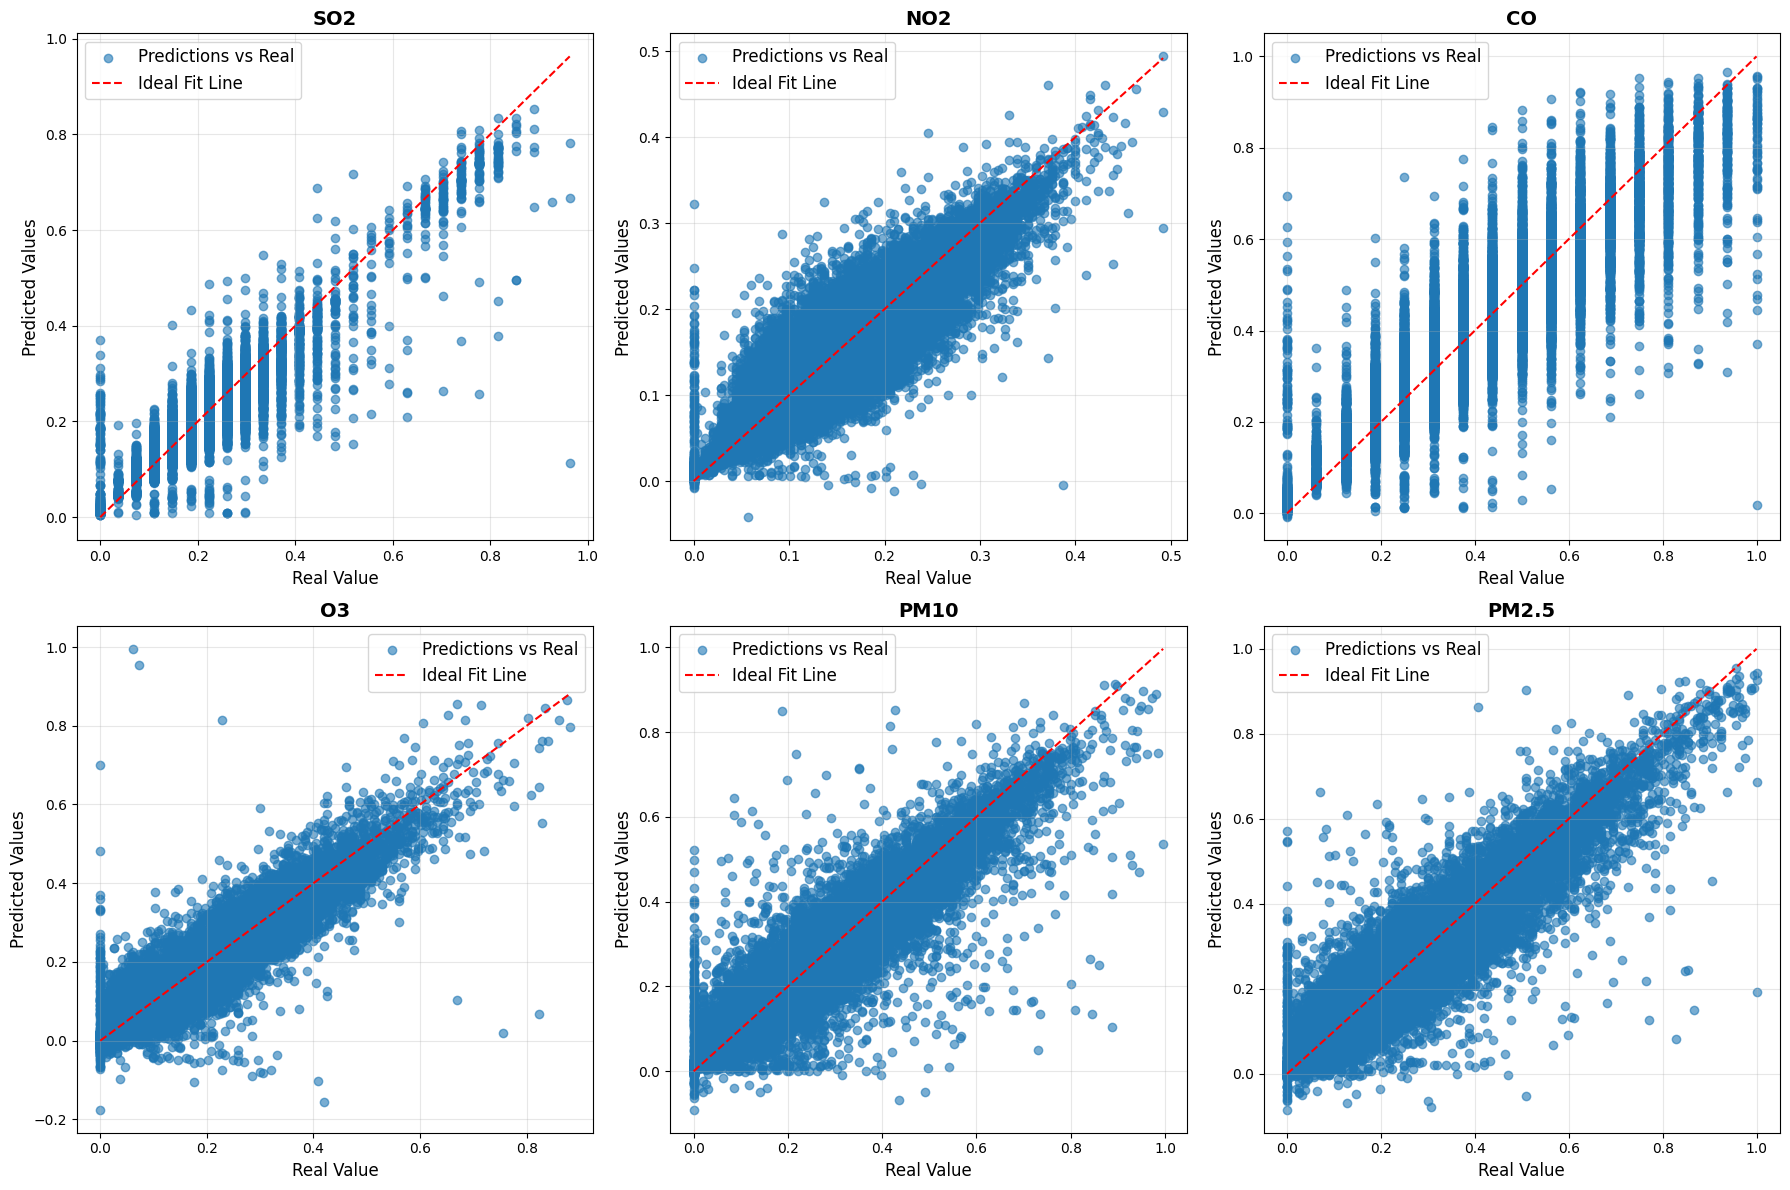



Overall results:
SO2: MSE=0.0006, R^2=0.8473
Error by category:
  - Good: MSE=0.0006
  - Normal: MSE=0.0208
  - Bad: MSE=nan
  - Very Bad: MSE=nan
NO2: MSE=0.0005, R^2=0.8874
Error by category:
  - Good: MSE=0.0003
  - Normal: MSE=0.0006
  - Bad: MSE=0.0012
  - Very Bad: MSE=nan
CO: MSE=0.0024, R^2=0.8707
Error by category:
  - Good: MSE=0.0024
  - Normal: MSE=nan
  - Bad: MSE=nan
  - Very Bad: MSE=nan
O3: MSE=0.0008, R^2=0.9140
Error by category:
  - Good: MSE=0.0006
  - Normal: MSE=0.0013
  - Bad: MSE=0.0067
  - Very Bad: MSE=0.0618
PM10: MSE=0.0012, R^2=0.9005
Error by category:
  - Good: MSE=0.0006
  - Normal: MSE=0.0010
  - Bad: MSE=0.0038
  - Very Bad: MSE=0.0193
PM2.5: MSE=0.0014, R^2=0.9032
Error by category:
  - Good: MSE=0.0007
  - Normal: MSE=0.0010
  - Bad: MSE=0.0027
  - Very Bad: MSE=0.0090


In [17]:
data = df_norm_originale.copy(deep=True)

# Aggiungo caratteristiche temporali
data['year'] = data['Measurement date'].dt.year
data['month'] = data['Measurement date'].dt.month
data['day'] = data['Measurement date'].dt.day
data['hour'] = data['Measurement date'].dt.hour
data['day_of_week'] = data['Measurement date'].dt.dayofweek

# Converto Station code in una variabile categoriale
data['Station code'] = data['Station code'].astype('category').cat.codes

# Dizionario per salvare i risultati
result_dict = {}

# Creo lag features per tutti gli inquinanti
lag_range = 10  # Numero di lag
for inquinante in inquinanti:
    for lag in range(1, lag_range + 1):
        data[f'{inquinante}_lag_{lag}'] = data[inquinante].shift(lag)

# Rimuovo righe con valori NaN generati dai lag
data = data.dropna()

# Modello per ogni inquinante
results = {}
n_inquinanti = len(inquinanti)  # Numero totale di inquinanti

# Creo una griglia di subplot con 2 righe e 3 colonne
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Dimensioni della griglia
axes = axes.flatten()

for idx, inquinante in enumerate(inquinanti):
    print(f"\nTraining model for {inquinante}...")
    
    # Estraggo le soglie per l'inquinante corrente
    thresholds = Measurement_item_info[Measurement_item_info['Item name'] == inquinante].iloc[0].to_dict()
    #print(thresholds)

    # Recupero i valori minimi e massimi per l'inquinante corrente
    min_value = Measurement_summary[inquinante].min()
    max_value = Measurement_summary[inquinante].max()

    # Normalizzo le soglie in base a questi minimi e massimi
    normalized_thresholds_dict = {}
    for key in ['Good(Blue)', 'Normal(Green)', 'Bad(Yellow)', 'Very bad(Red)']:
        # Prendi il valore della soglia, normalizzalo usando il MinMaxScaler
        normalized_value = (thresholds[key] - min_value) / (max_value - min_value)
        normalized_thresholds_dict[key] = normalized_value

    # Caratteristiche
    lag_features = [f'{p}_lag_{l}' for p in inquinanti for l in range(1, lag_range + 1)]
    time_features = ['year', 'month', 'day', 'hour', 'day_of_week']
    station_feature = ['Station code']
    features = lag_features + time_features + station_feature

    X = data[features]
    y = data[inquinante]

    # Divido in training e test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Valutazione
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[inquinante] = {'model': model, 'mse': mse, 'r2': r2, 'y_test': y_test, 'y_pred': y_pred}

    print(f"{inquinante} - Mean Squared Error: {mse}")
    print(f"{inquinante} - R^2 Score: {r2}")
    
    # Funzione di classificazione aggiornata per utilizzare le soglie normalizzate
    def classify_concentration_new(value, thresholds):
        if value <= thresholds['Good(Blue)']:
            return 'Good'
        elif value <= thresholds['Normal(Green)']:
            return 'Normal'
        elif value <= thresholds['Bad(Yellow)']:
            return 'Bad'
        else:
            return 'Very Bad'

    # Classifico i valori reali e predetti nelle categorie
    y_test_categories = y_test.apply(classify_concentration_new, thresholds=normalized_thresholds_dict)
    y_pred_categories = pd.Series([classify_concentration_new(val, normalized_thresholds_dict) for val in y_pred], index=y_test.index)

    # Calcolo l'errore per ciascuna categoria
    errors_by_category = {}
    for category in ['Good', 'Normal', 'Bad', 'Very Bad']:
        # Filtro dei dati per categoria
        category_indices = y_test_categories == category
        category_y_test = y_test[category_indices]
        category_y_pred = y_pred[category_indices]
        
        if len(category_y_test) > 0:
            mse_category = mean_squared_error(category_y_test, category_y_pred)
            errors_by_category[category] = mse_category
        else:
            errors_by_category[category] = np.nan 

    result_dict[inquinante] = {'mse': mse, 'r2': r2, 'category_errors': errors_by_category}

    # Grafico per Y Predette vs Y Vere
    ax = axes[idx]
    ax.scatter(y_test, y_pred, alpha=0.6, label='Predictions vs Real')
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit Line')
    ax.set_title(f"{inquinante}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Real Value", fontsize=12)
    ax.set_ylabel("Predicted Values", fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)

# Nasconde eventuali subplot vuoti se ci sono meno di 6 inquinanti
for idx in range(len(inquinanti), len(axes)):
    fig.delaxes(axes[idx])

# Ottimizzo la disposizione dei subplot
plt.tight_layout()
plt.show()

# Risultati finali
print("\n\nOverall results:")
for inquinante, metrics in result_dict.items():
    print(f"{inquinante}: MSE={metrics['mse']:.4f}, R^2={metrics['r2']:.4f}")
    print("Error by category:")
    for category, error in metrics['category_errors'].items():
        print(f"  - {category}: MSE={error:.4f}")